In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

import utils.sulfur.constant as const
from context_data_csv import ContextDataCSV
from matrix_optimizer import MatrixOptimizer

In [2]:
def create_columns(ref_ctx, cmp_ctx):
    column_df = pd.DataFrame()
    column_df['cell type'] = ['engram', 'engram', 'non-engram', 'non-engram']
    column_df['context'] = [ref_ctx, cmp_ctx] * 2
    return pd.MultiIndex.from_frame(column_df)

def split_engram_matrix(animal_name, context_name):
    csv = ContextDataCSV(animal_name, context_name)
    matrix = csv.data_frame
    matrix = MatrixOptimizer(matrix).divide_sd()
    
    engram_df = matrix.loc[:, csv.engram_cells()]
    non_engram_df = matrix.loc[:, csv.non_engram_cells()]
    
    return engram_df, non_engram_df

def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

In [6]:
def init_pairwise_distance_df(ref_ctx, cmp_ctx):
    index = const.ANIMAL_NAMES
    columns = create_columns(ref_ctx, cmp_ctx)
    across_session_df = pd.DataFrame(0.0, columns=columns, index=index)
    inner_session_df = pd.DataFrame(0.0, columns=columns, index=index)
    
    return across_session_df, inner_session_df

def calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames, cmp_frames):
    across_session_df, inner_session_df = init_pairwise_distance_df(ref_ctx, cmp_ctx)
    
    for animal_name in const.ANIMAL_NAMES:
        # ref context
        ref_engram_df, ref_non_engram_df = split_engram_matrix(animal_name, ref_ctx)
        
        ref_nan_engram_cells = all_nan_cells(ref_engram_df)
        ref_nan_non_engram_cells = all_nan_cells(ref_non_engram_df)
        
        # cmp context
        cmp_engram_df, cmp_non_engram_df = split_engram_matrix(animal_name, cmp_ctx)
        
        cmp_nan_engram_cells = all_nan_cells(cmp_engram_df)
        cmp_nan_non_engram_cells = all_nan_cells(cmp_non_engram_df)
        
        # fetch dropped cells
        dropped_engram_cells = droped_unique_cells(ref_nan_engram_cells, cmp_nan_engram_cells)
        dropped_non_engram_cells = droped_unique_cells(ref_nan_non_engram_cells, cmp_nan_non_engram_cells)
        
        # ref context
        ref_engram_df.drop(columns=dropped_engram_cells, inplace=True)
        ref_non_engram_df.drop(columns=dropped_non_engram_cells, inplace=True)
        
        ref_engram_df = ref_engram_df.iloc[ref_frames[0]:ref_frames[1], :]
        ref_non_engram_df = ref_non_engram_df.iloc[ref_frames[0]:ref_frames[1], :]
        
        # cmp context
        cmp_engram_df.drop(columns=dropped_engram_cells, inplace=True)
        cmp_non_engram_df.drop(columns=dropped_non_engram_cells, inplace=True)
        
        cmp_engram_df = cmp_engram_df.iloc[cmp_frames[0]:cmp_frames[1], :]
        cmp_non_engram_df = cmp_non_engram_df.iloc[cmp_frames[0]:cmp_frames[1], :]
        
        across_session_df.loc[animal_name, ('engram', ref_ctx)] = np.mean(pairwise_distances(ref_engram_df, ref_engram_df))
        across_session_df.loc[animal_name, ('engram', cmp_ctx)] = np.mean(pairwise_distances(ref_engram_df, cmp_engram_df))
        
        across_session_df.loc[animal_name, ('non-engram', ref_ctx)] = np.mean(pairwise_distances(ref_non_engram_df, ref_non_engram_df))
        across_session_df.loc[animal_name, ('non-engram', cmp_ctx)] = np.mean(pairwise_distances(ref_non_engram_df, cmp_non_engram_df))
        
        inner_session_df.loc[animal_name, ('engram', ref_ctx)] = np.mean(pairwise_distances(ref_engram_df, ref_engram_df))
        inner_session_df.loc[animal_name, ('engram', cmp_ctx)] = np.mean(pairwise_distances(cmp_engram_df, cmp_engram_df))
        
        inner_session_df.loc[animal_name, ('non-engram', ref_ctx)] = np.mean(pairwise_distances(ref_non_engram_df, ref_non_engram_df))
        inner_session_df.loc[animal_name, ('non-engram', cmp_ctx)] = np.mean(pairwise_distances(cmp_non_engram_df, cmp_non_engram_df))
        
    return across_session_df, inner_session_df
    
def view_pairwise_distance_bar(across_session_df, inner_session_df, ref_ctx, cmp_ctx):
    engram_across_df = across_session_df.iloc[:, 0:2]
    non_engram_across_df = across_session_df.iloc[:, 2:]
    
    engram_inner_df = inner_session_df.iloc[:, 0:2]
    non_engram_inner_df = inner_session_df.iloc[:, 2:]
    
    base_session_color = 'lightsteelblue'
    
    xticklabels = [ref_ctx, cmp_ctx, '%s v.s %s' % (ref_ctx, cmp_ctx)]
    
    fig, axes = plt.subplots(ncols=2, figsize=(20, 10), dpi=200)
    axes[0].set_title('engram', fontsize=20)
    axes[0].bar(x=0, height=engram_inner_df.iloc[:, 0].mean(), yerr=engram_inner_df.iloc[:, 0].sem(), capsize=8, align='center',color=base_session_color)
    axes[0].bar(x=1, height=engram_inner_df.iloc[:, 1].mean(), yerr=engram_inner_df.iloc[:, 1].sem(), capsize=8, align='center',color='indianred')
    axes[0].bar(x=2, height=engram_across_df.iloc[:, 1].mean(), yerr=engram_across_df.iloc[:, 1].sem(), capsize=8, align='center',color=base_session_color, linewidth=10, edgecolor='indianred')
    axes[0].set_xticks([0, 1, 2])
    axes[0].set_xticklabels(xticklabels, fontsize=20)
    axes[0].tick_params(axis='y', labelsize=20)
    
    axes[1].set_title('non-engram', fontsize=20)
    axes[1].bar(x=0, height=non_engram_inner_df.iloc[:, 0].mean(), yerr=non_engram_inner_df.iloc[:, 0].sem(), capsize=8, align='center',color=base_session_color)
    axes[1].bar(x=1, height=non_engram_inner_df.iloc[:, 1].mean(), yerr=non_engram_inner_df.iloc[:, 1].sem(), capsize=8, align='center',color='navy')
    axes[1].bar(x=2, height=non_engram_across_df.iloc[:, 1].mean(), yerr=non_engram_across_df.iloc[:, 1].sem(), capsize=8, align='center',color=base_session_color, linewidth=10, edgecolor='navy')
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_xticklabels(xticklabels, fontsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    
    fig.tight_layout()
    fig.show()

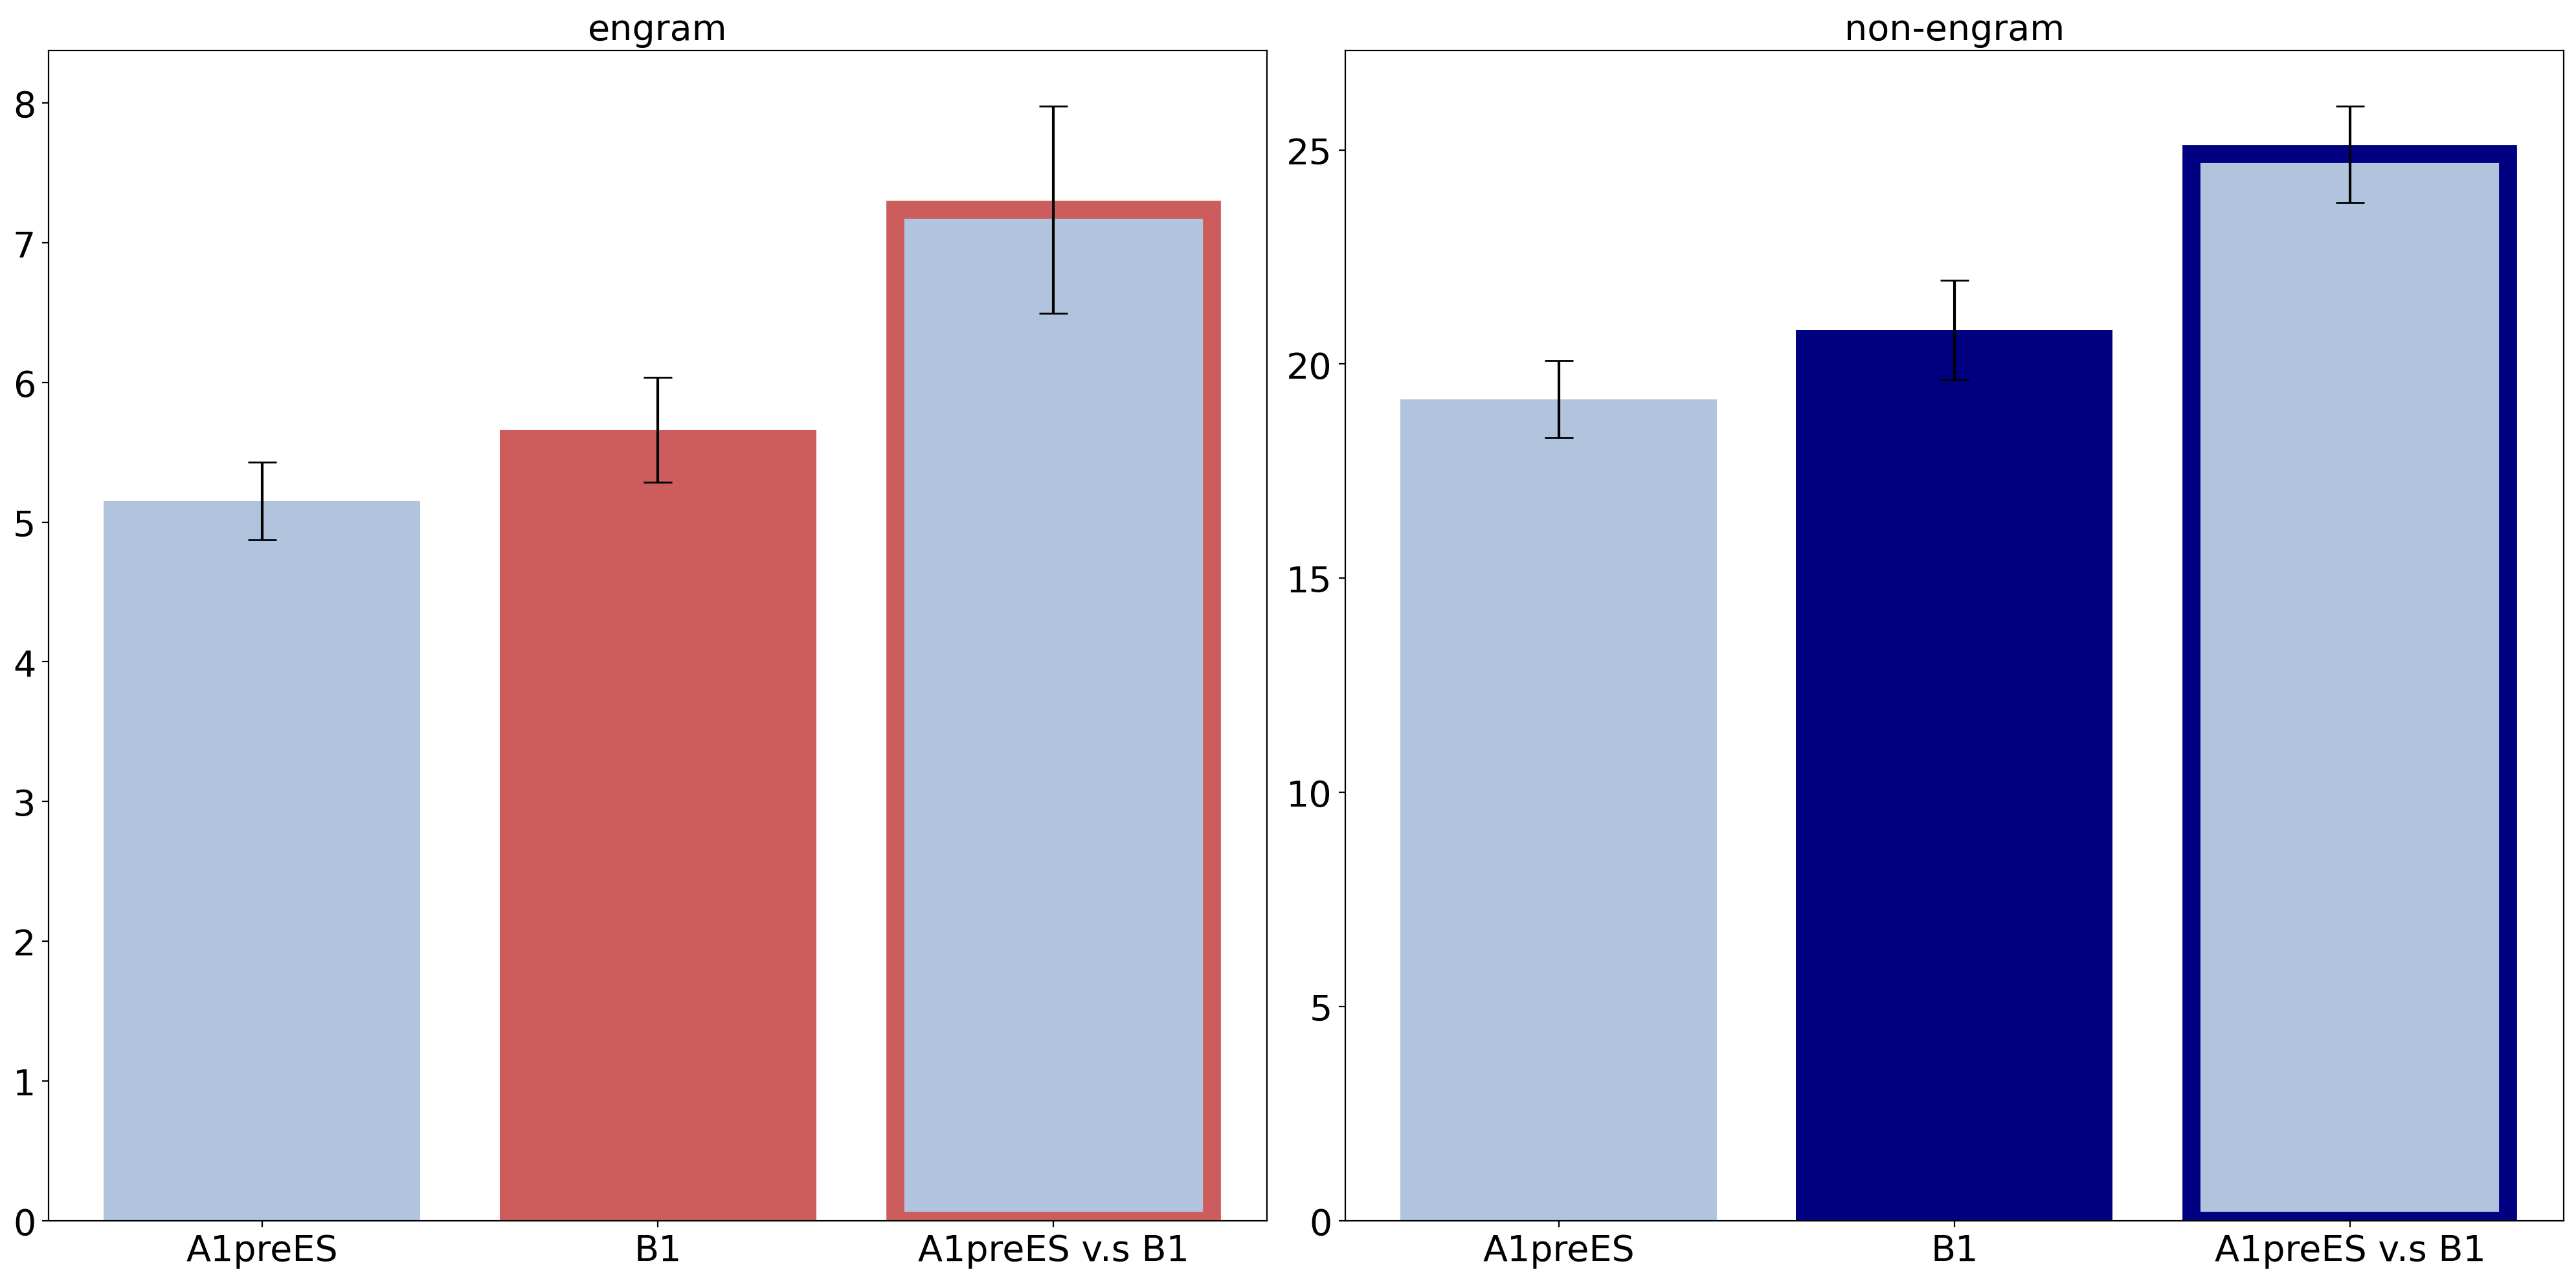

In [7]:
ref_ctx = 'A1preES'
cmp_ctx = 'B1'
across_session_df, inner_session_df = calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames=[2601, 3001], cmp_frames=[2601, 3001])
view_pairwise_distance_bar(across_session_df, inner_session_df, ref_ctx, cmp_ctx)

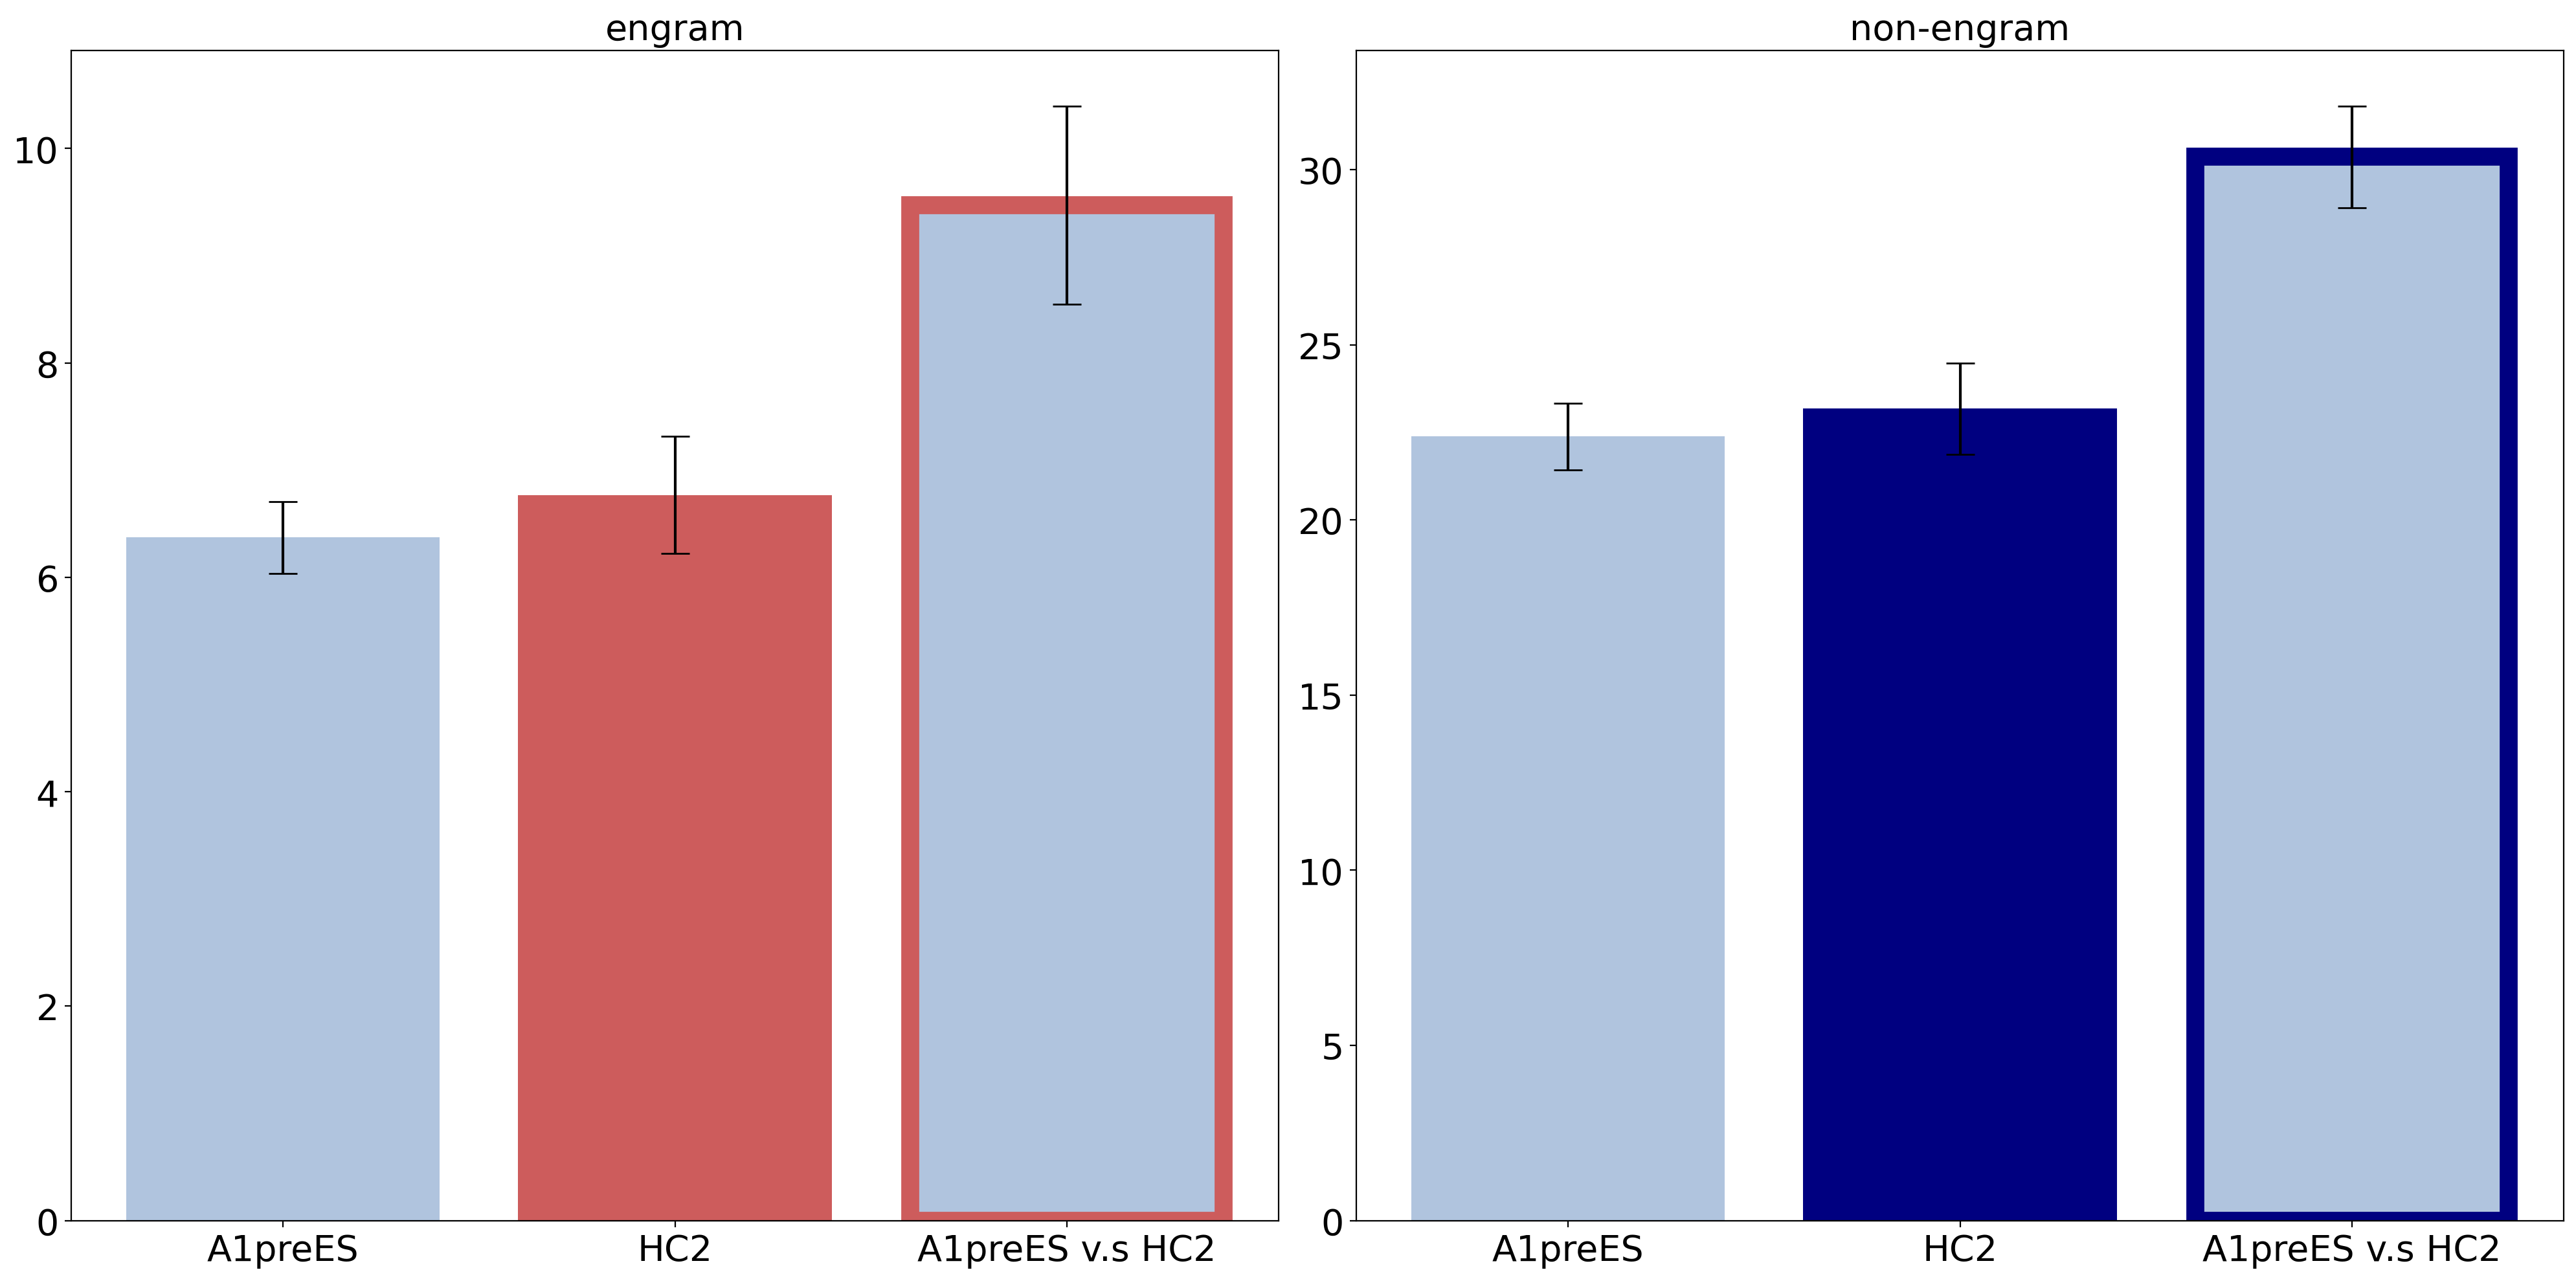

In [8]:
ref_ctx = 'A1preES'
cmp_ctx = 'HC2'
across_session_df, inner_session_df = calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames=[2601, 3001], cmp_frames=[5601, 6001])
view_pairwise_distance_bar(across_session_df, inner_session_df, ref_ctx, cmp_ctx)

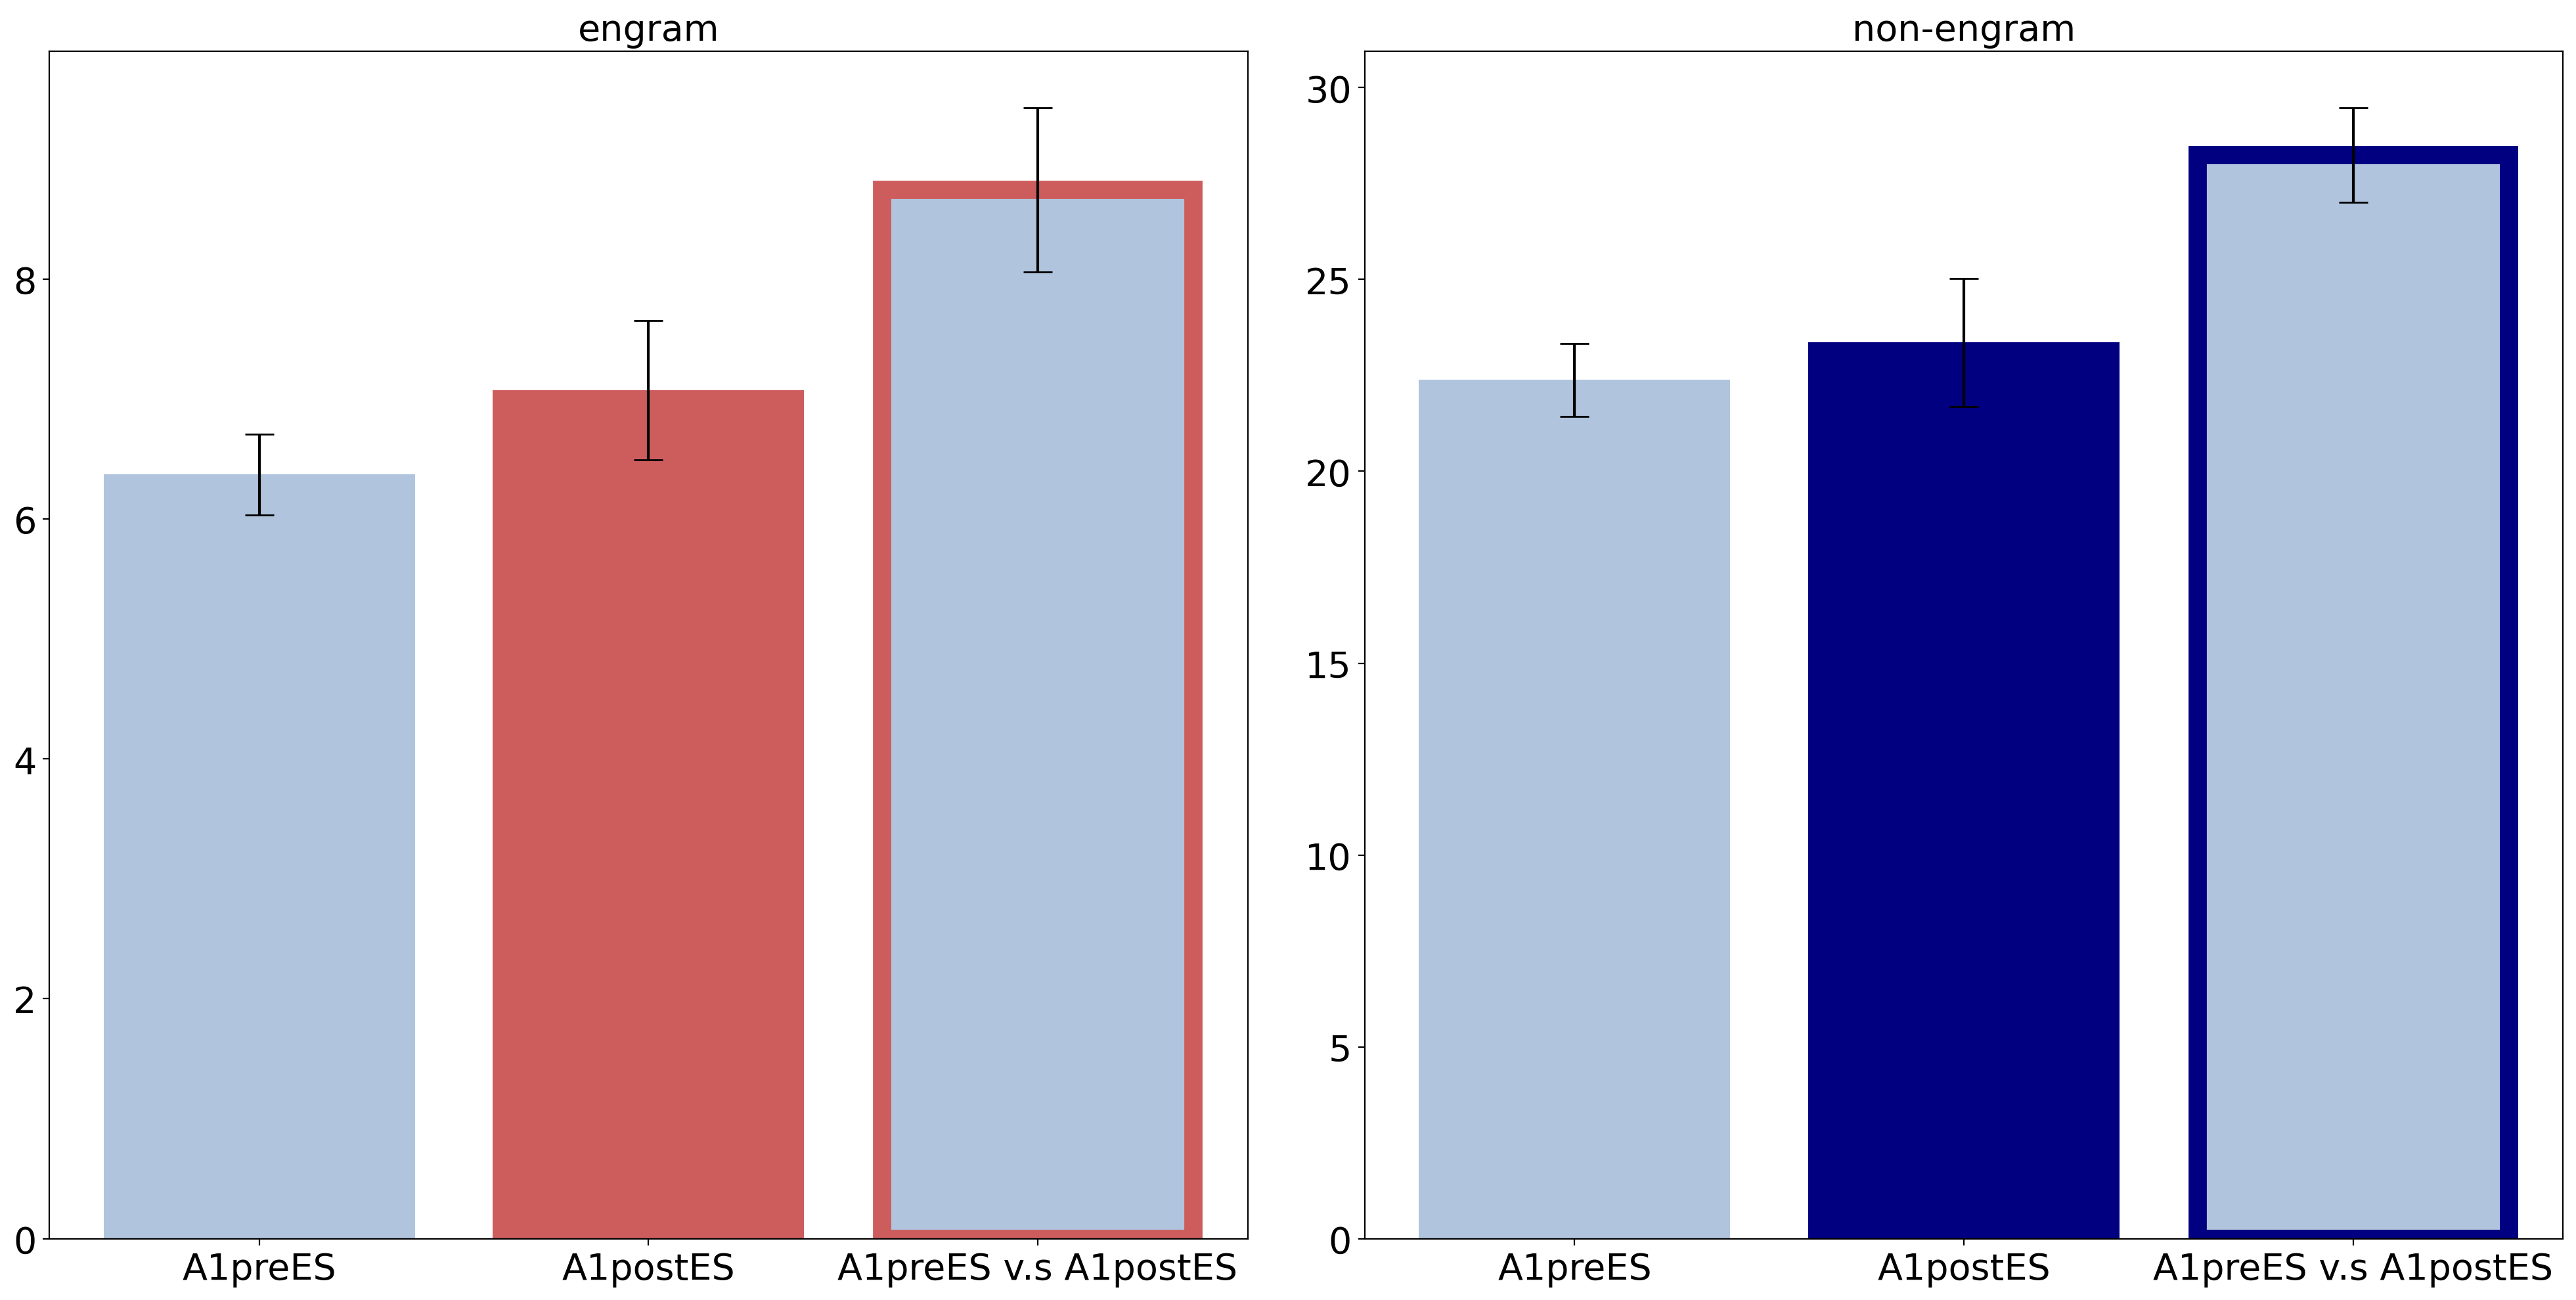

In [11]:
ref_ctx = 'A1preES'
cmp_ctx = 'A1postES'
a1_across_session_df, a1_inner_session_df = calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames=[2601, 3001], cmp_frames=[1800, 2200])
view_pairwise_distance_bar(a1_across_session_df, a1_inner_session_df, ref_ctx, cmp_ctx)

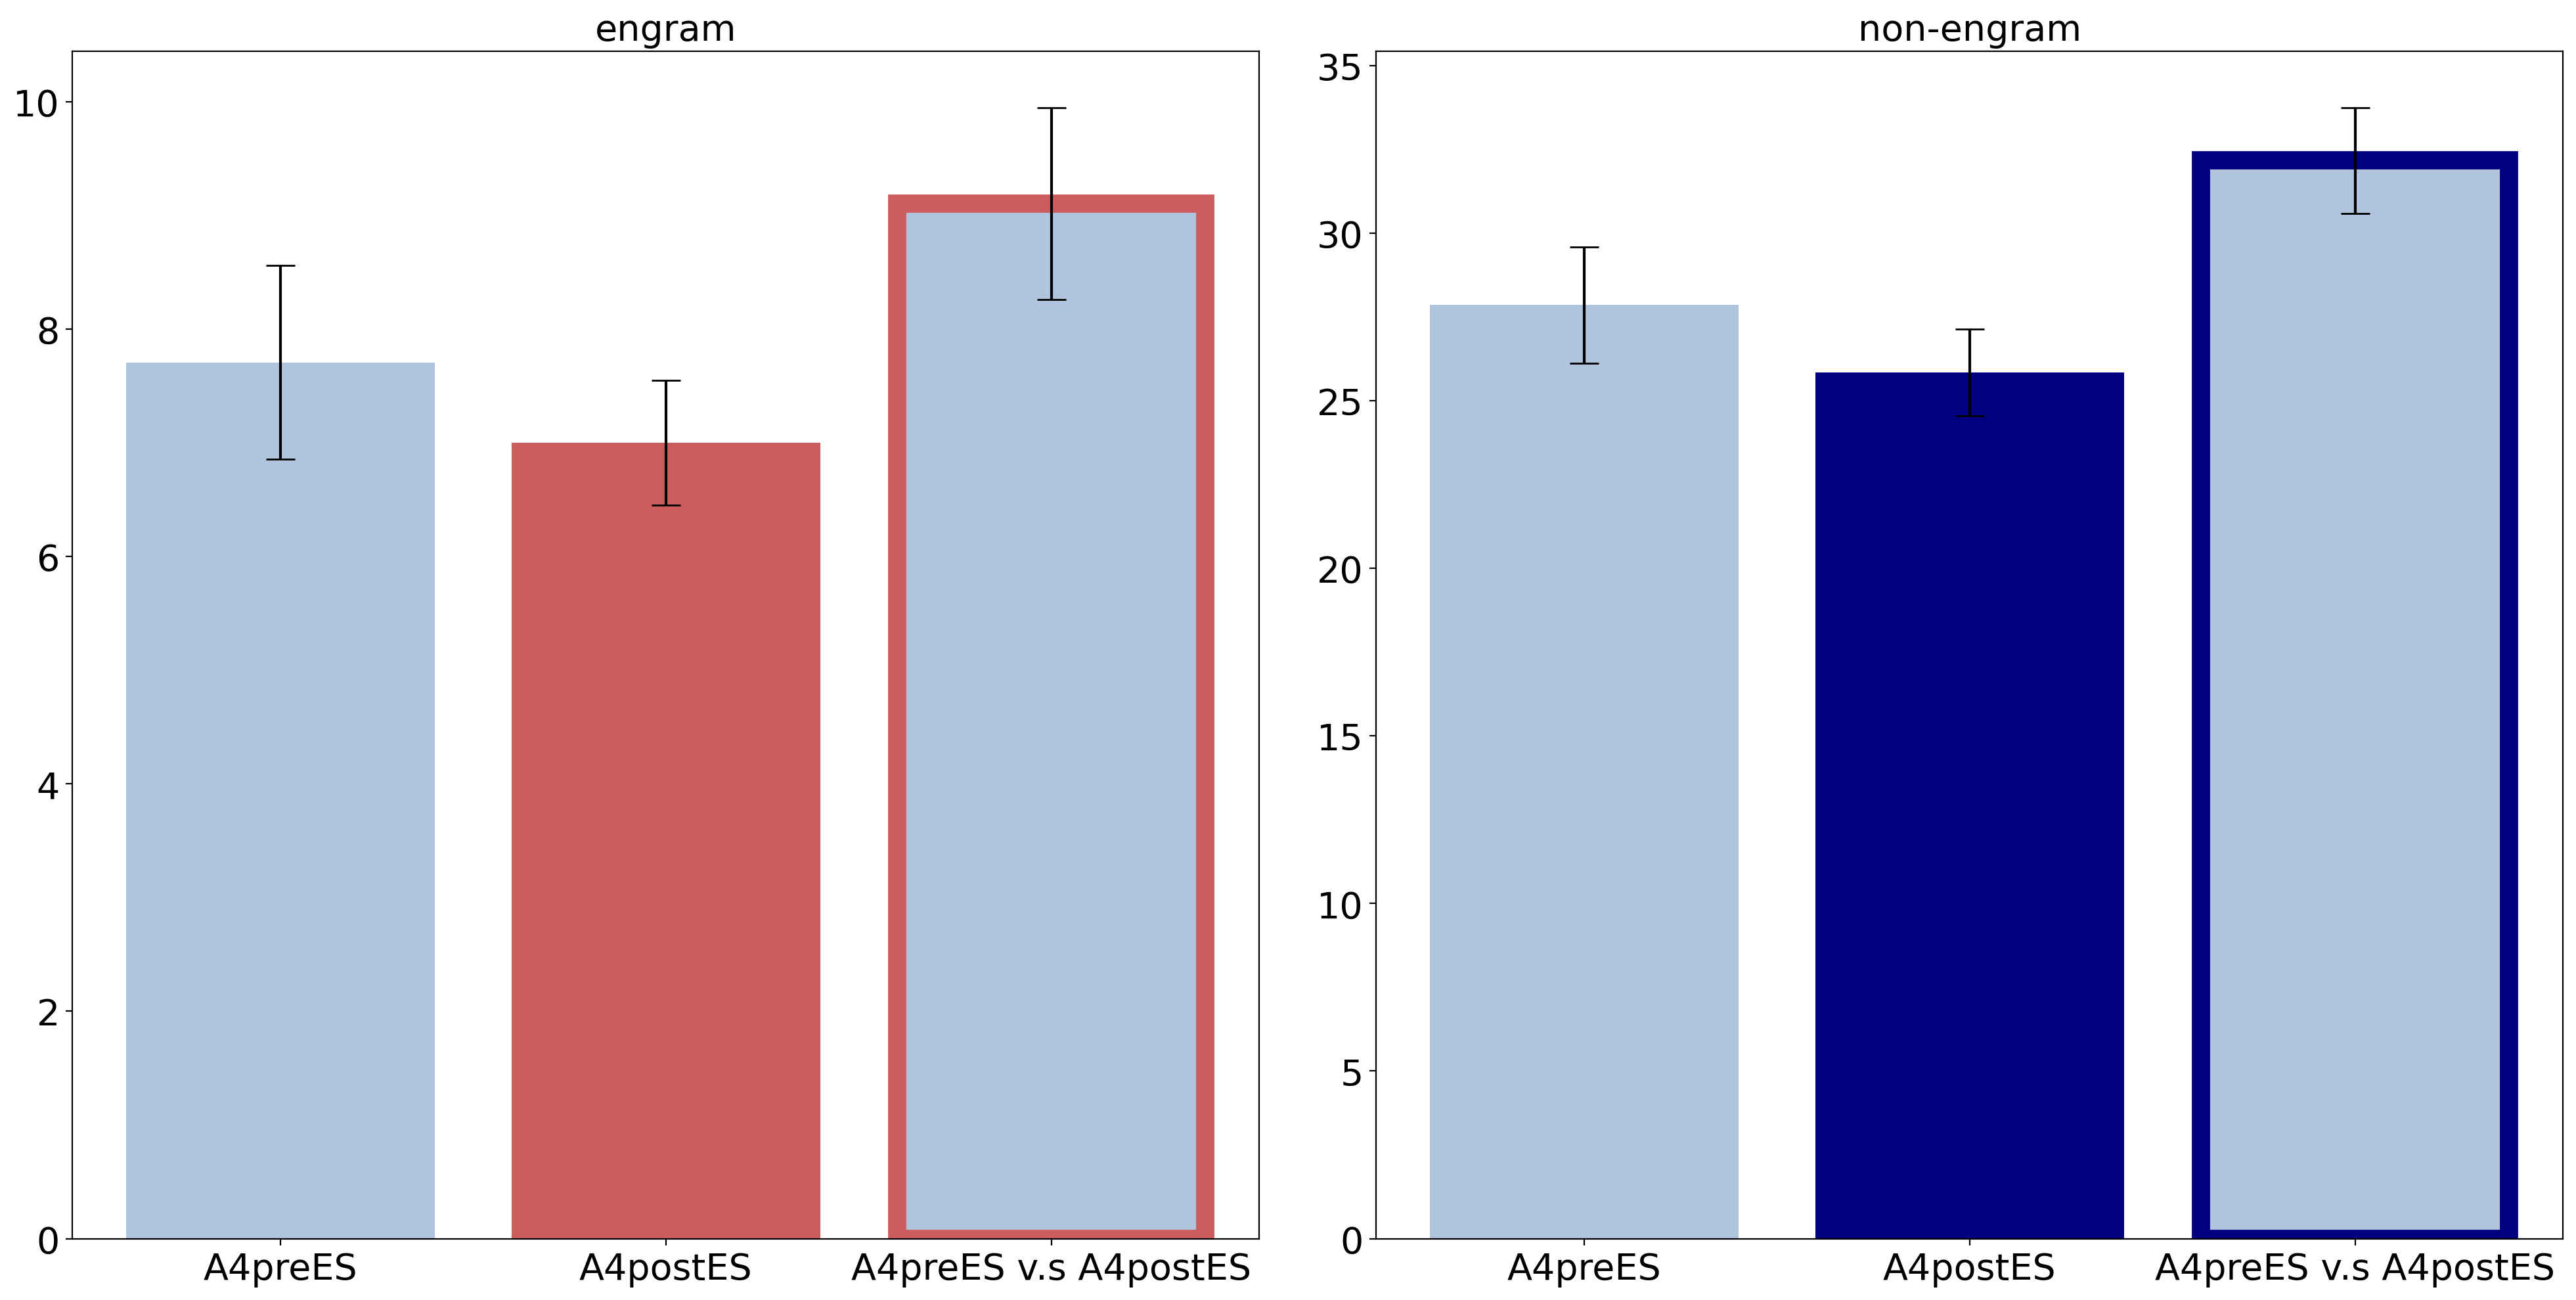

In [12]:
ref_ctx = 'A4preES'
cmp_ctx = 'A4postES'
a4_across_session_df, a4_inner_session_df = calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames=[2601, 3001], cmp_frames=[1800, 2200])
view_pairwise_distance_bar(a4_across_session_df, a4_inner_session_df, ref_ctx, cmp_ctx)

In [13]:
a1_inner_session_df

cell type       engram            non-engram           
context        A1preES   A1postES    A1preES   A1postES
ID181106CreA  6.643553   8.457493  23.483914  28.087477
ID181106CreB  7.199640   6.160772  19.429744  17.298816
ID181106CreC  5.692085   6.340856  20.478193  21.312219
ID181106CreG  6.853755   7.173196  24.272037  26.595724
ID181106CreH  8.139986  11.398241  21.151433  26.217843
ID181106CreI  7.371520   6.077693  16.404233  12.377022
ID181106CreK  6.129761   5.943086  23.191131  20.949198
ID181106CreL  4.614989   6.331602  23.933254  26.390661
ID181106CreN  5.530515   7.928975  25.296404  28.298147
ID181106CreQ  5.528634   4.913318  26.182569  26.032701

In [14]:
a4_inner_session_df

cell type        engram            non-engram           
context         A4preES   A4postES    A4preES   A4postES
ID181106CreA   9.729732   7.829872  32.055208  29.842234
ID181106CreB   5.946424   5.962596  21.658948  19.902151
ID181106CreC   9.368796   7.722691  25.631383  23.703093
ID181106CreG   9.820726   7.189996  34.626613  26.063396
ID181106CreH   6.444455  10.487069  19.348759  28.829847
ID181106CreI  13.095531   8.806350  24.709877  18.452821
ID181106CreK   5.948647   6.110483  25.102127  25.400738
ID181106CreL   4.664468   5.493613  27.760251  27.910734
ID181106CreN   4.976408   5.080222  35.107383  30.918200
ID181106CreQ   7.068328   5.327321  32.503851  27.407480

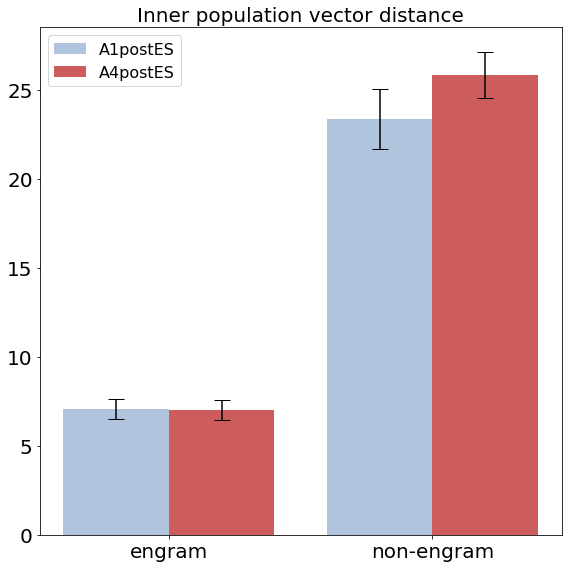

In [40]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

xticklabels = np.array(['engram', 'non-engram'])

a1_inner_df = pd.DataFrame(a1_inner_session_df.iloc[:, [1, 3]])
a4_inner_df = pd.DataFrame(a4_inner_session_df.iloc[:, [1, 3]])

left = np.arange(-0.1, 2.1, 2.0)
width = 0.40

ax.set_title('Inner population vector distance', fontsize=20)
ax.bar(x=left - width, height=a1_inner_df.mean(), yerr=a1_inner_df.sem(), capsize=8, align='center',color='lightsteelblue', label='A1postES')
ax.bar(x=left + width, height=a4_inner_df.mean(), yerr=a4_inner_df.sem(), capsize=8, align='center',color='indianred', label='A4postES')
ax.set_xticks([-0.1, 1.9])
ax.set_xticklabels(xticklabels, fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(fontsize=16)

fig.show()

In [41]:
from scipy import stats

In [42]:
a1_inner_df

cell type,engram,non-engram
context,A1postES,A1postES
ID181106CreA,8.457493,28.087477
ID181106CreB,6.160772,17.298816
ID181106CreC,6.340856,21.312219
ID181106CreG,7.173196,26.595724
ID181106CreH,11.398241,26.217843
ID181106CreI,6.077693,12.377022
ID181106CreK,5.943086,20.949198
ID181106CreL,6.331602,26.390661
ID181106CreN,7.928975,28.298147


In [43]:
a4_inner_df

cell type,engram,non-engram
context,A4postES,A4postES
ID181106CreA,7.829872,29.842234
ID181106CreB,5.962596,19.902151
ID181106CreC,7.722691,23.703093
ID181106CreG,7.189996,26.063396
ID181106CreH,10.487069,28.829847
ID181106CreI,8.806350,18.452821
ID181106CreK,6.110483,25.400738
ID181106CreL,5.493613,27.910734
ID181106CreN,5.080222,30.918200


In [45]:
_, pvalue = stats.ttest_rel(a1_inner_df.iloc[:, 0], a4_inner_df.iloc[:, 0])
pvalue

0.8815604192590266

In [46]:
_, pvalue = stats.ttest_rel(a1_inner_df.iloc[:, 1], a4_inner_df.iloc[:, 1])
pvalue

0.0016945202876792454